DM2 - Wadi Moughanim

Exercise 2.1 (Quantile estimation with simulated data):

(Recommended R package: evd.)
Generate $n = 1e + 5$ independent data $X_i$, $i \leq n$ from a Fréchet distribution with c.d.f.
$$G_{a,b,\alpha}(x) = e^{-[(x-b)/a]^{-\alpha}}$$
with $\alpha = 3$, $b = 1$, $a = 0$. In the sequel pretend that you don’t know the true distribution.

In [1]:
# Install and load the evd package
install.packages("evd")
library(evd)


Les packages binaires t'el'echarg'es sont dans
	/var/folders/2t/t_blrm1n6z7fln5ts2692m6r0000gn/T//RtmphyXdu8/downloaded_packages


Les packages binaires t'el'echarg'es sont dans
	/var/folders/2t/t_blrm1n6z7fln5ts2692m6r0000gn/T//RtmpJAYJB6/downloaded_packages

a and b are inverted in the library

In [2]:
# Parameters
n <- 1e5
a <- 0     # loc
b <- 1      # scale
s <- 3      # shape

# Generate data from the Fréchet distribution
Xi <- rfrechet(n, loc = a, scale = b, shape = s)

head(Xi)


[1] 0.8762790 1.0710294 1.2458376 2.9233813 0.8186263 1.3854458

1.75487208647028 1.67516455664457 1.52102088027035 1.44431253764505 1.78807891887364 1.21763797884454

We obtain some data from the Frechet distribution, but as the Frechet distribution is very simple with theses parameters, we can compute easily the cdf and compare it with the empirical cdf.

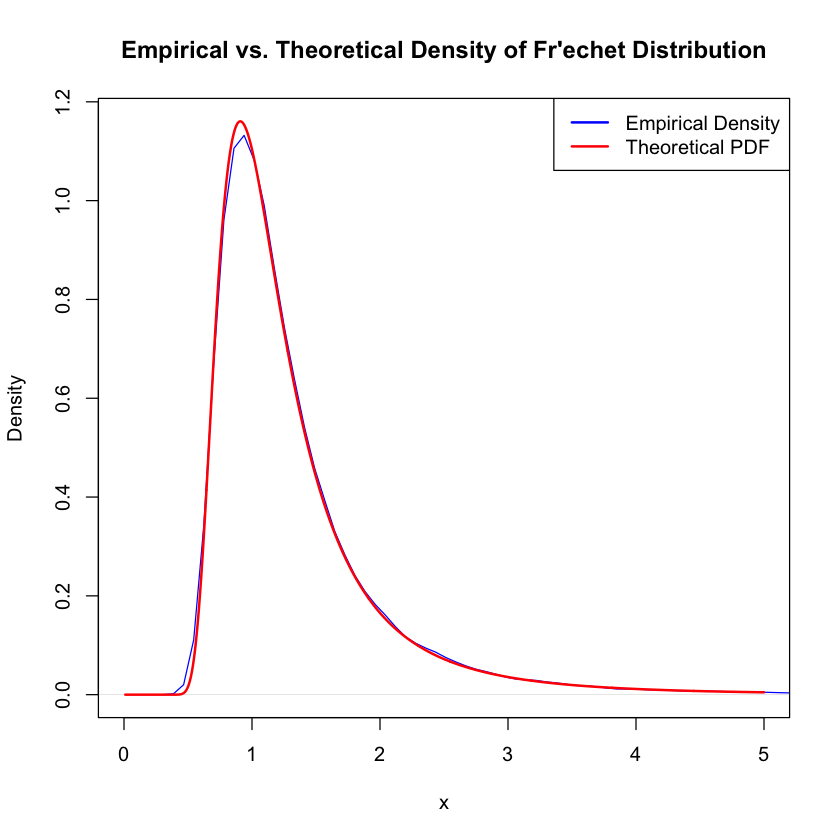

In [3]:
x_vals <- seq(0.01, 5, length.out = 1000)  # Values for x
pdf_vals <- 3 * x_vals^(-4) * exp(-x_vals^(-3))  # Theoretical PDF

density_estimation <- density(Xi)

# Plotting the estimated density
plot(density_estimation, main = "Empirical vs. Theoretical Density of Fréchet Distribution", xlab = "x", ylab = "Density", xlim = c(0,5), ylim=c(0, max(density_estimation$y, pdf_vals)), col = "blue")

# Overlaying the theoretical PDF of the Fréchet distribution

lines(x_vals, pdf_vals, col = "red", lwd = 2)

legend("topright", legend = c("Empirical Density", "Theoretical PDF"), col = c("blue", "red"), lwd = 2)


It fits pretty well.

1. Fit a GPD distribution above some threshold $t$. Choose $t$ with a stability plot (function
tcplot).

We first try to find the threshold $t$ with the stability plot.

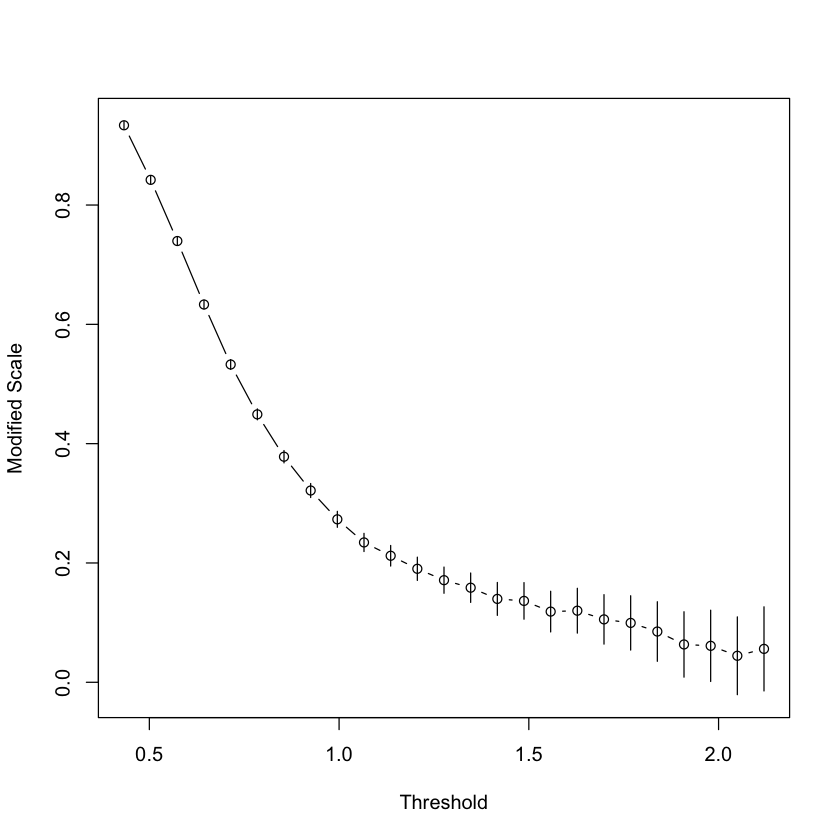

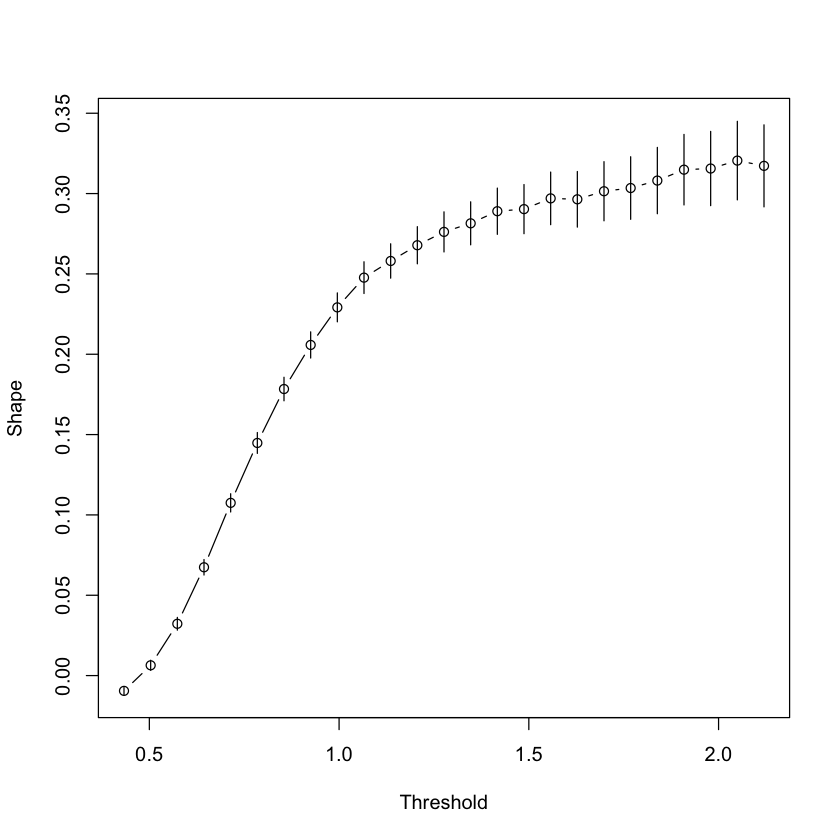

In [4]:
library(evd)

# Define the ran age of thresholds to be used in tcplot
tlim <- c(min(Xi), quantile(Xi, 0.9))

tcplot(Xi, tlim=tlim)


Based on what we see on the stability plot, the shape parameter begnis to show more consitent and gradual since x = 1, I choose 1.5 to take a little margin that ensure us to have a good stability without being too conservative.

In [5]:
threshold = 1.5

In [6]:
library(evir)


Attachement du package : 'evir'


Les objets suivants sont masqu'es depuis 'package:evd':

    dgev, dgpd, pgev, pgpd, qgev, qgpd, rgev, rgpd




Attachement du package : 'evir'


Les objets suivants sont masqu'es depuis 'package:evd':

    dgev, dgpd, pgev, pgpd, qgev, qgpd, rgev, rgpd

We then fit the GPD distribution with the threshold.

In [7]:
gpd_fit <- gpd(Xi, threshold)

2. Estimate the quantile $z_p$ of the distribution of the $X_i$ at level $p = 1-5.10^{-4}$, using a plug-in
method based on the GPD model above $t$ and an empirical estimate $\hat{\zeta}$ of $\zeta = P(X_1 > t)$.


Given the formula from the lesson (2.12):

In [8]:
threshold <- 1.5
p <- 5e-4

# Estimate zeta_hat
zeta_hat <- sum(Xi > threshold) / length(Xi)

# from GPD fit
gamma <- gpd_fit$par.ests[1]  
sigma <- gpd_fit$par.ests[2]  

# Solving for x using 2.12
x <- (sigma / gamma) * ((zeta_hat / (1 - p))^(-gamma) - 1)

# Compute z_p
z_p <- threshold + x
z_p


beta 
2.448927

2.45372492145804

We obtain a quantile of $z_p = 2.45$ using a plug-in method based on the GPD model above $t$ and an empirical estimate $\hat{\zeta}$ of $\zeta = P(X_1 > t)$.


3. Investigate the variability of the quantile estimator based on a Monte-Carlo approximation.
Namely repeat the experiment $Nexpe = 100$ times (which means simulating $Nexpe$ datasets).
For each replication $i$, fit a GPD model above some fixed threshold and use it to estimate
a quantile $\hat{z}_i$. In the end, consider the empirical interquantile range (e.g. at level 0.90)
of the $\hat{z}_i$’s. Does the true quantile belong to this interquantile range? Compute the mean
squared error (based on the $Nexpe$ experiments) of the quantile estimate.



In [9]:
Nexpe <- 100
threshold <- 1.5
quantile_estimates <- numeric(Nexpe)

n <- length(Xi)
a <- 0     # loc
b <- 1     # scale
s = 3    # shape
p <- 5e-4  # Probability for quantile

for (i in 1:Nexpe) {
  
  # Simulate data from the Frechet distribution
  simulated_data <- rfrechet(n, loc = a, scale = b, shape = s)
  
  # Fit GPD with exception handling
  try({
    gpd_fit <- gpd(simulated_data, threshold)
    
    sigma <- gpd_fit$par.ests[2]
    gamma <- gpd_fit$par.ests[1]
    
    # Estimate zeta_hat for simulated data
    zeta_hat_simulated <- sum(simulated_data > threshold) / length(simulated_data)
    
    # Solving for x using the relationship
    x <- (sigma / gamma) * ((zeta_hat_simulated / (1 - p))^(-gamma) - 1)

    # Compute z_p for simulated data
    quantile_estimates[i] <- threshold + x
    
  }, silent=TRUE)
}

# Remove NA values from quantile_estimates
quantile_estimates <- quantile_estimates[!is.na(quantile_estimates)]

# Compute empirical interquantile range and other metrics
lower_bound <- quantile(quantile_estimates, 0.05)
upper_bound <- quantile(quantile_estimates, 0.95)

true_quantile <- 2.45
belongs <- lower_bound <= true_quantile & true_quantile <= upper_bound
mse <- mean((quantile_estimates - true_quantile)^2)

list(IQR = c(lower_bound, upper_bound), TrueQuantileBelongs = belongs, MSE = mse)


$IQR
      5%      95% 
2.442642 2.471368 

$TrueQuantileBelongs
  5% 
TRUE 

$MSE
[1] 0.0001220319

The true quantile belongs to the range even though the very low mean squared error.

4. Repeat the latter question (i.e. compute the mean squared error) with a Fréchet shape
$\alpha = 1.1$, and $\alpha = 10$ (you may have to change your threshold). Comment on how the
shape parameter affects the mean squared error.

We first want to assess the treshold for the two new shape parameters.

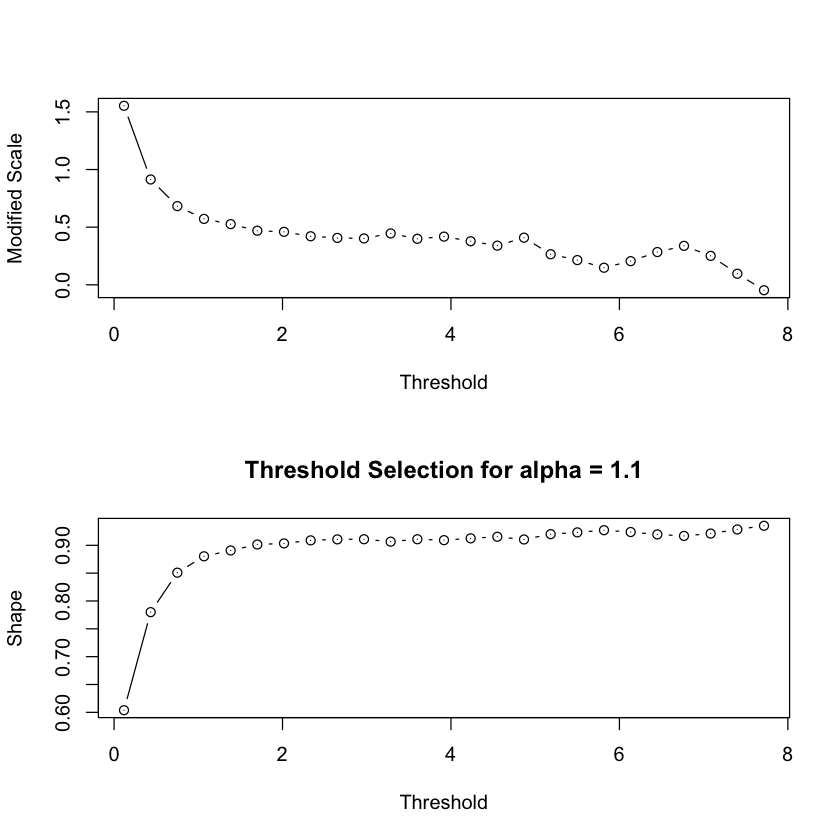

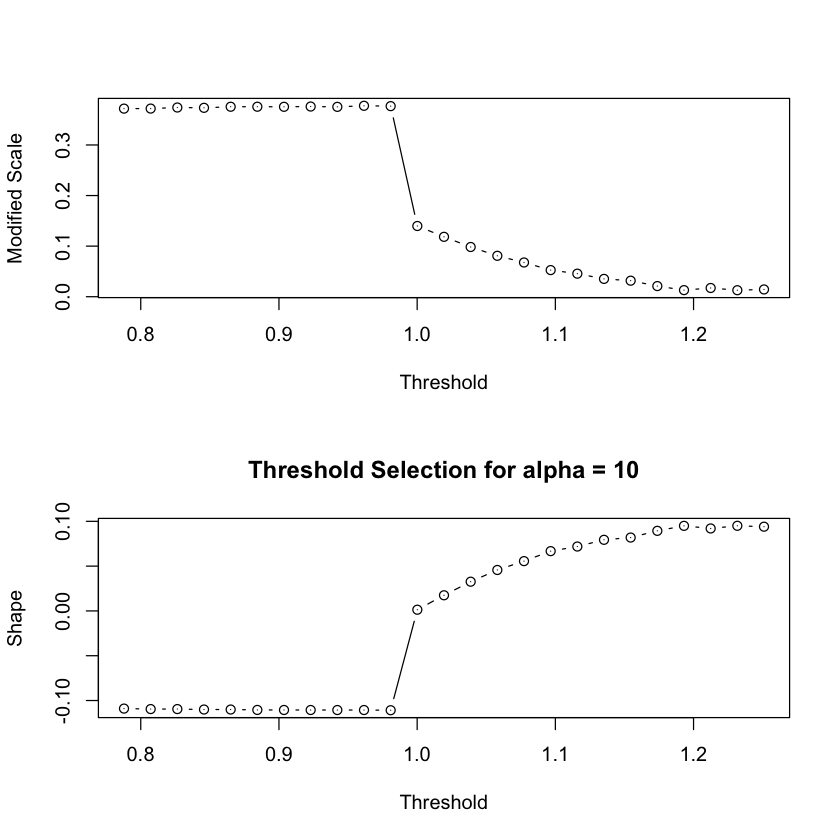

In [10]:
n <- length(Xi)
a <- 0  
b <- 1  
alphas <- c(1.1, 10)

par(mfrow=c(2,1))  

for(alpha in alphas) {
  Xi <- rfrechet(n, loc = a, scale = b, shape = alpha)
  tlim <- c(min(Xi), quantile(Xi, 0.9))
  tcplot(Xi, tlim=tlim, std.err=FALSE)
  title(main=paste("Threshold Selection for alpha =", alpha))
}

par(mfrow=c(1,1))  


we can assess that for alpha = 2.1 the treshold can be set at 1.1 wich sounds logical since with alpha increasing the tail is becoming less heavy.

In [11]:
Nexpe <- 100
threshold <- 2.5
quantile_estimates <- numeric(Nexpe)

# Frechet distribution parameters
n <- length(Xi)
a <- 0     # loc
b <- 1     # scale
s = 1.1    # shape
p <- 5e-4  # Probability for quantile

for (i in 1:Nexpe) {
  
  # Simulate data from the Frechet distribution
  simulated_data <- rfrechet(n, loc = a, scale = b, shape = s)
  
  # Fit GPD with exception handling
  try({
    gpd_fit <- gpd(simulated_data, threshold)
    
    sigma <- gpd_fit$par.ests[2]
    gamma <- gpd_fit$par.ests[1]
    
    # Estimate zeta_hat for simulated data
    zeta_hat_simulated <- sum(simulated_data > threshold) / length(simulated_data)
    
    # Solving for x using the relationship
    x <- (sigma / gamma) * ((zeta_hat_simulated / (1 - p))^(-gamma) - 1)

    # Compute z_p for simulated data
    quantile_estimates[i] <- threshold + x
    
  }, silent=TRUE)
}

quantile_estimates <- quantile_estimates[!is.na(quantile_estimates)]
lower_bound <- quantile(quantile_estimates, 0.05)
upper_bound <- quantile(quantile_estimates, 0.95)
mse <- mean((quantile_estimates - true_quantile)^2)
list(IQR = c(lower_bound, upper_bound),  MSE = mse)


$IQR
      5%      95% 
8.137696 8.357021 

$MSE
[1] 33.74499

In [12]:
Nexpe <- 100
threshold <- 1.1
quantile_estimates <- numeric(Nexpe)

# Frechet distribution parameters
n <- length(Xi)
a <- 0     # loc
b <- 1     # scale
s = 10    # shape
p <- 5e-4  # Probability for quantile

for (i in 1:Nexpe) {
  
  # Simulate data from the Frechet distribution
  simulated_data <- rfrechet(n, loc = a, scale = b, shape = s)
  
  # Fit GPD with exception handling
  try({
    gpd_fit <- gpd(simulated_data, threshold)
    
    sigma <- gpd_fit$par.ests[2]
    gamma <- gpd_fit$par.ests[1]
    
    # Estimate zeta_hat for simulated data
    zeta_hat_simulated <- sum(simulated_data > threshold) / length(simulated_data)
    
    # Solving for x using the relationship
    x <- (sigma / gamma) * ((zeta_hat_simulated / (1 - p))^(-gamma) - 1)
    # Compute z_p for simulated data
    quantile_estimates[i] <- threshold + x
    
  }, silent=TRUE)
}
quantile_estimates <- quantile_estimates[!is.na(quantile_estimates)]
# Compute empirical interquantile range and other metrics
lower_bound <- quantile(quantile_estimates, 0.05)
upper_bound <- quantile(quantile_estimates, 0.95)
mse <- mean((quantile_estimates - true_quantile)^2)
list(IQR = c(lower_bound, upper_bound),  MSE = mse)


$IQR
      5%      95% 
1.247997 1.251451 

$MSE
[1] 1.440405

The shape parameter $ \alpha $ of the Fréchet distribution has a profound impact on the tail behavior and the subsequent GPD fitting results. For $ \alpha = 1.1 $, which represents a heavy tail, we observe a higher threshold of 2.5 and a notably large Mean Squared Error (MSE) of 34. This significant MSE suggests that the extreme quantile estimates can deviate substantially from the true values, especially when trying to model the tail of such a heavy-tailed distribution. In contrast, when $ \alpha = 10 $, indicating a lighter tail, the required threshold drops to 1.1 and the MSE shrinks to 1.4. This stark difference in MSE values between the two scenarios emphasizes the impact of alpha on the tail behavior and the subsequent GPD fitting results.
